In [1]:
import sys
sys.path.append('../src')

import numpy as np
from veg_dataset import VegetationDataModule
from model import MultiClassVegetationModel
from training import training_setup
import imageio
import glob
import matplotlib.pyplot as plt
import rasterio
from datetime import datetime
from rasterio.transform import Affine
import torch
from skimage.transform import rotate
import math

c:\Users\Akshat\anaconda3\envs\lua_torch\lib\site-packages\albumentations\__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.14). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [ ]:
best_model = MultiClassVegetationModel(
    out_channels=4,
    in_channels=5, 
    backbone='resnet50',
    class_weights=None
).cuda()

best_model.load_state_dict(torch.load('../saved_models/patch_unet_resnet50_4patch_unet_resnet50-{epoch}/last.ckpt')['state_dict'], strict=False)

C:\Users\Akshat\AppData\Local\Temp\ipykernel_23124\3265980868.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load('../saved_models/pat

_IncompatibleKeys(missing_keys=[], unexpected_keys=['loss_fn.weight'])

In [ ]:
test_mask = imageio.imread('C:/Users/Akshat/Desktop/ayan code/job/beethoven code/test_prediction_color_mask.png')

shape = test_mask.shape
reshaped_test_mask = test_mask.reshape(-1, 3)

# RGB to class mapping
mapping = [
    [0, 0, 0],
    [0, 255, 0],
    [255, 255, 0],
    [255, 0, 0],
]

# Convert mapping to a numpy array for efficient comparison
mapping = np.array(mapping)

# Create a new array for storing class indices
class_indices = np.zeros(reshaped_test_mask.shape[0], dtype=np.uint8)

for i, val in enumerate(mapping):
    class_indices[np.all(reshaped_test_mask == val, axis=1)] = i

# Reshape back to the original mask shape
reshaped_test_mask = class_indices.reshape(shape[0], shape[1])

C:\Users\Akshat\AppData\Local\Temp\ipykernel_16376\1870939014.py:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  test_mask = imageio.imread('C:/Users/Akshat/Desktop/ayan code/job/beethoven code/test_prediction_color_mask.png')


In [2]:

def min_max_norm(img):
    return (img - np.min(img, axis=(0,1)))/(np.max(img, axis=(0,1)) - np.min(img, axis=(0,1)))


def read_band(ds,idx):
    band = ds.read(idx)
    return min_max_norm(np.where(band == ds.nodata, 0, band))


def rotate_crop(img, angle):
    corrected_image = rotate(img, angle=angle, reshape=True)

    # Find the rows and columns where the values are non-zero
    non_zero_rows = np.where(np.any(corrected_image != 0, axis=1))[0]
    non_zero_cols = np.where(np.any(corrected_image != 0, axis=0))[0]
    # Get the first and last non-zero rows and columns
    row_start, row_end = non_zero_rows[0], non_zero_rows[-1]
    col_start, col_end = non_zero_cols[0], non_zero_cols[-1]

    # Crop the image using the identified bounds
    cropped_image = corrected_image[row_start:row_end + 1, col_start:col_end + 1]
    return cropped_image, non_zero_rows, non_zero_cols


def util(dataset, angle=-13.25):
    B,G,R, rededge = read_band(dataset, 1), read_band(dataset, 2), read_band(dataset, 3), read_band(dataset, 6)    
    rededge, nir = read_band(dataset, 4), read_band(dataset, 5)
    
    data = np.dstack([R,G,B, rededge, nir])
    
    nt = dataset.transform
    
    if angle != 0:        
        data, non_zero_rows, non_zero_cols = rotate_crop(data, angle=angle)
        ot = dataset.transform
        angle_rad = math.radians(angle)

        # Calculate rotation terms
        cos_theta = math.cos(angle_rad)
        sin_theta = math.sin(angle_rad)

        b_new = ot.a * sin_theta
        d_new = ot.e * sin_theta

        # New origin after cropping
        row_start, col_start = non_zero_rows[0], non_zero_cols[0]
        new_origin_x, new_origin_y = ot * (col_start, row_start)

        # Create new Affine transform
        nt = Affine(
            ot.a * cos_theta, b_new, new_origin_x,
            d_new, ot.e * cos_theta, new_origin_y
        )
    
        return min_max_norm(data), nt, non_zero_rows, non_zero_cols

    return min_max_norm(data), nt


def normalize(image, min_percentile=0.5, max_percentile=99.5):
    # Initialize output array
    normalized_image = np.zeros_like(image, dtype=np.float32)
    
    # Normalize each RGB channel based on percentiles
    for channel in range(image.shape[-1]):  # Assuming image has 3 channels (RGB)
        channel_data = image[:, :, channel]
        
        # Compute min and max values for the channel based on percentiles
        min_val = np.percentile(channel_data, min_percentile)
        max_val = np.percentile(channel_data, max_percentile)
        
        normalized_image[:, :, channel] = np.clip((channel_data - min_val) / (max_val - min_val), 0, 1)
    
    return normalized_image

In [ ]:
test_path = glob.glob('../data/test_tif/*')[0]

output_mask_tiff = '../test_prediction_mask.tiff'
output_image_tiff = '../test_input_image.tiff'

with rasterio.open(test_path) as dataset:
    meta = dataset.meta
    cropped_image, nt = util(dataset=dataset)
    print(cropped_image.shape)
    
    # Update metadata for the mask
    meta.update(
        transform=nt,
        count=1,  # Only 1 band for the mask
        nodata=np.nan,
        dtype='float32',
        height=cropped_image.shape[0],
        width=cropped_image.shape[1]
    )
    with rasterio.open(output_mask_tiff, 'w', **meta) as dst:
        dst.write(reshaped_test_mask.astype('float32'), 1)  # Write to the first (and only) band

    # Update metadata for the image
    meta.update(
        transform=nt,
        count=3,  # 3 bands for RGB
        nodata=np.nan,
        dtype='float32',
        height=cropped_image.shape[0],
        width=cropped_image.shape[1]
    )

    # Transpose the cropped image to match (bands, height, width)
    cropped_image_transposed = cropped_image.transpose(2, 0, 1)

    with rasterio.open(output_image_tiff, 'w', **meta) as dst:
        print(meta)
        dst.write(cropped_image_transposed.astype('float32'))  # Write all bands

(3182, 1460, 3)
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 1460, 'height': 3182, 'count': 3, 'crs': CRS.from_epsg(4326), 'transform': Affine(5.614441829009899e-08, -1.3220255628371917e-08, 9.913989287852013,
       8.240258294532349e-09, -3.4995125776070704e-08, 51.56036566937967)}


# TIME PLOTS

In [63]:
time_tiffs = glob.glob('../by_plots/*')
time_tiffs.extend(glob.glob('../data/test_tif/*'))

In [ ]:
with rasterio.open(time_tiffs[4], 'r') as dataset:
    # B,G,R, thermal = read_band(dataset, 1), read_band(dataset, 2), read_band(dataset, 3), read_band(dataset, 6)    
    rededge, nir = read_band(dataset, 4), read_band(dataset, 5)
    
    fig, axs = plt.subplots(1,2,figsize=(10,10))
    axs[0].imshow(rededge)
    axs[0].axis('off')
    
    axs[1].imshow(nir)
    axs[1].axis('off')
    
    plt.tight_layout()
    plt.show()

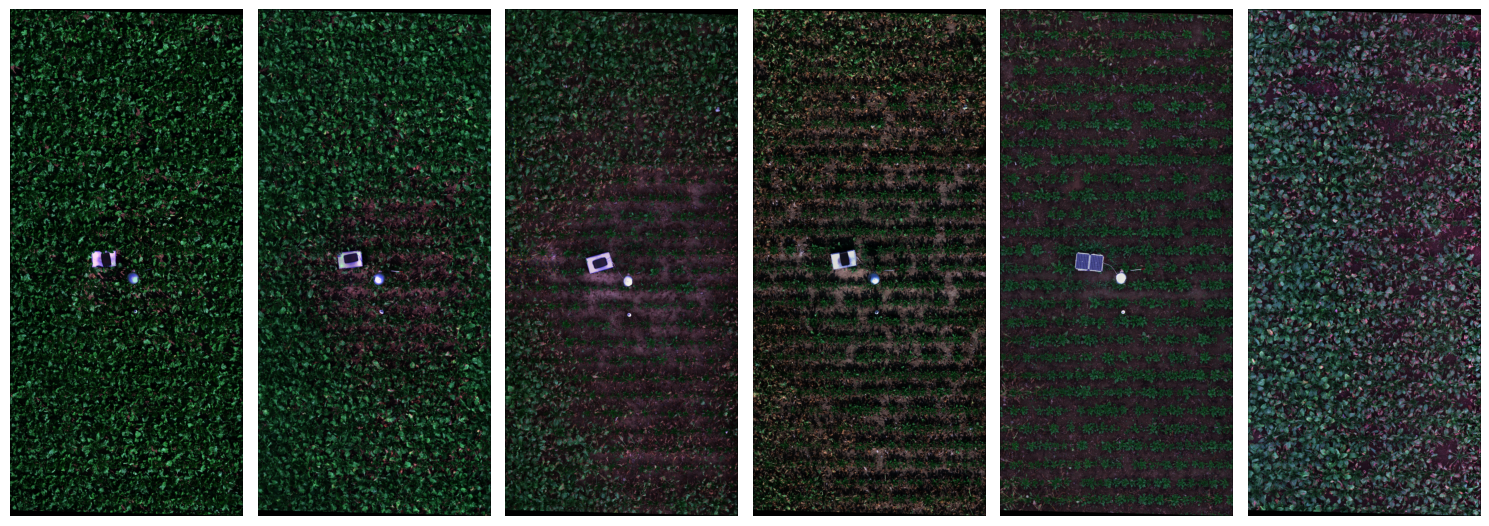

In [200]:
fig, axes = plt.subplots(1, 6, figsize=(15, 10))  # 1 row, 5 columns of subplots
final_images = []

# Loop through the files and create subplots
for i, tiff in enumerate(time_tiffs):
    with rasterio.open(tiff, 'r') as ortho:
        # file_name = tiff.split("\\")[-1]  # Get the file name: "1w_20200722_Multi_ortho.tif"
        # date_str = file_name.split("_")[1]  # Extract the date part: "20200722"
        # date_readable = datetime.strptime(date_str, "%Y%m%d").strftime("%d %B %Y")  # e.g., "22 July 2020"

        # Process the TIFF file
        img1, nt = util(ortho)
        final_images.append(img1[...,:3])

        # Plot the image in the subplot
        axes[i].imshow(img1[...,:3])
        
        # axes[i].set_title(f"Image {i+1}\n{date_readable}")  # Add a title with the date
        axes[i].axis('off')  # Turn off axes for cleaner visualization
# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [105]:
def generate_patches(image):
    patch_size = 128
    overlap = patch_size // 2  # 50% overlap
    height, width = image.shape[:2]

    # Initialize a list to store patches
    patches = []

    # Loop over the image with a 50% overlap
    for y in range(0, height, overlap):
        for x in range(0, width, overlap):
            # Adjust coordinates to prevent overflow beyond the image dimensions
            y_end = min(y + patch_size, height)
            x_end = min(x + patch_size, width)
            
            # Extract patch and resize if necessary
            patch = image[y:y_end, x:x_end]
            
            # If the patch is smaller than 128x128 due to overflow adjustment, pad it
            if patch.shape[0] < patch_size or patch.shape[1] < patch_size:
                patch = np.pad(patch, ((0, patch_size - patch.shape[0]), (0, patch_size - patch.shape[1]), (0, 0)), mode='constant')
            
            # Append patch to the list
            patches.append(patch)

    # Stack patches into a NumPy array
    patches_array = np.stack(patches)
    
    return patches_array


In [106]:
from tqdm.notebook import tqdm

all_patches = []

for i, tiff in tqdm(enumerate(time_tiffs)):
    with rasterio.open(tiff, 'r') as ortho:
        img1, nt = util(ortho)
        patches = generate_patches(img1)
        
        all_patches.append(patches)

0it [00:00, ?it/s]

In [108]:
all_preds = []

for test_img in all_patches:
    test_preds = []
    for img in tqdm(test_img):
        img = torch.tensor(img).permute(-1,0,1).unsqueeze(0).cuda()
        pred = torch.softmax(best_model(img.cuda()).detach().cpu(), dim=1)
        # pred = torch.argmax(pred,dim=1)
        test_preds.append(pred)

    test_preds = torch.concat(test_preds)
    all_preds.append(test_preds)

  0%|          | 0/1150 [00:00<?, ?it/s]

  0%|          | 0/1150 [00:00<?, ?it/s]

  0%|          | 0/1150 [00:00<?, ?it/s]

  0%|          | 0/1150 [00:00<?, ?it/s]

  0%|          | 0/1150 [00:00<?, ?it/s]

In [ ]:
all_preds[0]

torch.Size([1150, 128, 128, 4])

In [180]:
fig, axs = plt.subplots(1,2,figsize=(10,5))

i = 4
j = 0
axs[0].imshow(all_patches[i][j,...,:3])
axs[0].axis('off')
axs[1].imshow(all_patches[i][j,...,:3])
axs[1].imshow(torch.argmax(all_preds[i], dim=-1)[j], alpha=0.8)
axs[1].axis('off')
plt.tight_layout()
plt.show()

# plt.imshow(all_patches[0][0,...,:3])
# plt.imshow(torch.argmax(all_preds[0], dim=1)[0], alpha=0.5)
# plt.axis('off')
# plt.show()

In [125]:
from scipy.ndimage import gaussian_filter

# Assuming full image and weight_sum are tensors now
# full_height, full_width, num_classes = 3182, 1460, 4
full_height, full_width, num_classes = 3182, 1461, 4
full_image = torch.zeros((full_height, full_width, num_classes), dtype=torch.float32)
weight_sum = torch.zeros((full_height, full_width, 1), dtype=torch.float32)

# Define base_weight_mask in NumPy and convert to torch.Tensor for consistency
base_weight_mask_np = np.zeros((128, 128))
base_weight_mask_np[64, 64] = 1
base_weight_mask_np = gaussian_filter(base_weight_mask_np, sigma=32)
base_weight_mask = torch.tensor(base_weight_mask_np, dtype=torch.float32)

# Iterate over patches and apply weight mask
patch_size, stride = 128, 64
patch_index = 0

In [126]:
all_preds = [img.permute(0,2,3,1) for img in all_preds]

In [127]:
final_masks = []
for test_pred in tqdm(all_preds):
    patch_index = 0
    for y in range(0, full_height, stride):
        for x in range(0, full_width, stride):
            patch = test_pred[patch_index]
            
            # Adjust weight mask for edge patches
            weight_mask = base_weight_mask.clone()  # Ensure a fresh copy for each patch
            if y + patch_size > full_height:
                weight_mask[(full_height - y):, :] = 0
            if x + patch_size > full_width:
                weight_mask[:, (full_width - x):] = 0

            # Apply adjusted weight mask to the patch
            # print(patch.shape, weight_mask.shape)
            weighted_patch = patch * weight_mask[..., None]

            # Define slice range
            y_end = min(y + patch_size, full_height)
            x_end = min(x + patch_size, full_width)

            # Accumulate predictions and weights
            full_image[y:y_end, x:x_end] = full_image[y:y_end, x:x_end] + weighted_patch[:y_end - y, :x_end - x]
            weight_sum[y:y_end, x:x_end] = weight_sum[y:y_end, x:x_end] + weight_mask[:y_end - y, :x_end - x, None]

            patch_index += 1
            
    full_image /= torch.maximum(weight_sum, torch.tensor(1.0))
    final_prediction = torch.argmax(full_image, dim=-1)
    final_masks.append(final_prediction)

  0%|          | 0/5 [00:00<?, ?it/s]

In [159]:
colored_pred_masks = []

for test_pred_mask in final_masks:
    if isinstance(test_pred_mask, torch.Tensor):
        test_pred_mask = test_pred_mask.numpy()
    # final_image = (final_prediction * (255 / final_prediction.max())).astype(np.uint8)
    # image = Image.fromarray(final_image)
    # image.save("test_prediction_mask.png", dpi=(600, 600))

    color_map = {
        0: (0, 0, 0),         # Background - Black
        1: (0, 150, 0),       # Class 1 - Green
        2: (255, 255, 0),     # Class 2 - Yellow
        3: (255, 0, 0),       # Class 3 - Red
    }

    height, width = test_pred_mask.shape
    color_image = np.zeros((height, width, 3), dtype=np.uint8)

    for class_index, color in color_map.items():
        color_image[test_pred_mask == class_index] = color

    colored_pred_masks.append(color_image)
    # Image.fromarray(color_image).save("test_prediction_color_mask.png", dpi=(600, 600))

In [189]:
import pandas as pd
import numpy as np

# Suppress scientific notation
np.set_printoptions(suppress=True)

# Initialize an empty list to store each mask's proportions
data = []

for test_pred_mask in final_masks:
    counts = np.unique(test_pred_mask, return_counts=True)[1]
    proportions = counts / np.sum(counts)
    data.append(proportions)

# Create a DataFrame with the specified column names
df = pd.DataFrame(data, columns=['background', 'vegetation', 'sick', 'spots'])

print(df)

   background  vegetation      sick     spots
0    0.151720    0.830241  0.016994  0.001045
1    0.106277    0.882104  0.011513  0.000106
2    0.158559    0.826345  0.015069  0.000028
3    0.177420    0.808754  0.013819  0.000008
4    0.238701    0.751466  0.009831  0.000002


In [183]:
from PIL import Image

In [188]:
for i, (img, mask) in enumerate(zip(final_images, colored_pred_masks)):
    Image.fromarray(np.uint8(img * 255)).save(f"test_input_img_{i+1}.png", dpi=(1200, 1200))
    Image.fromarray(mask).save(f"test_pred_color_mask_{i+1}.png", dpi=(1200, 1200))

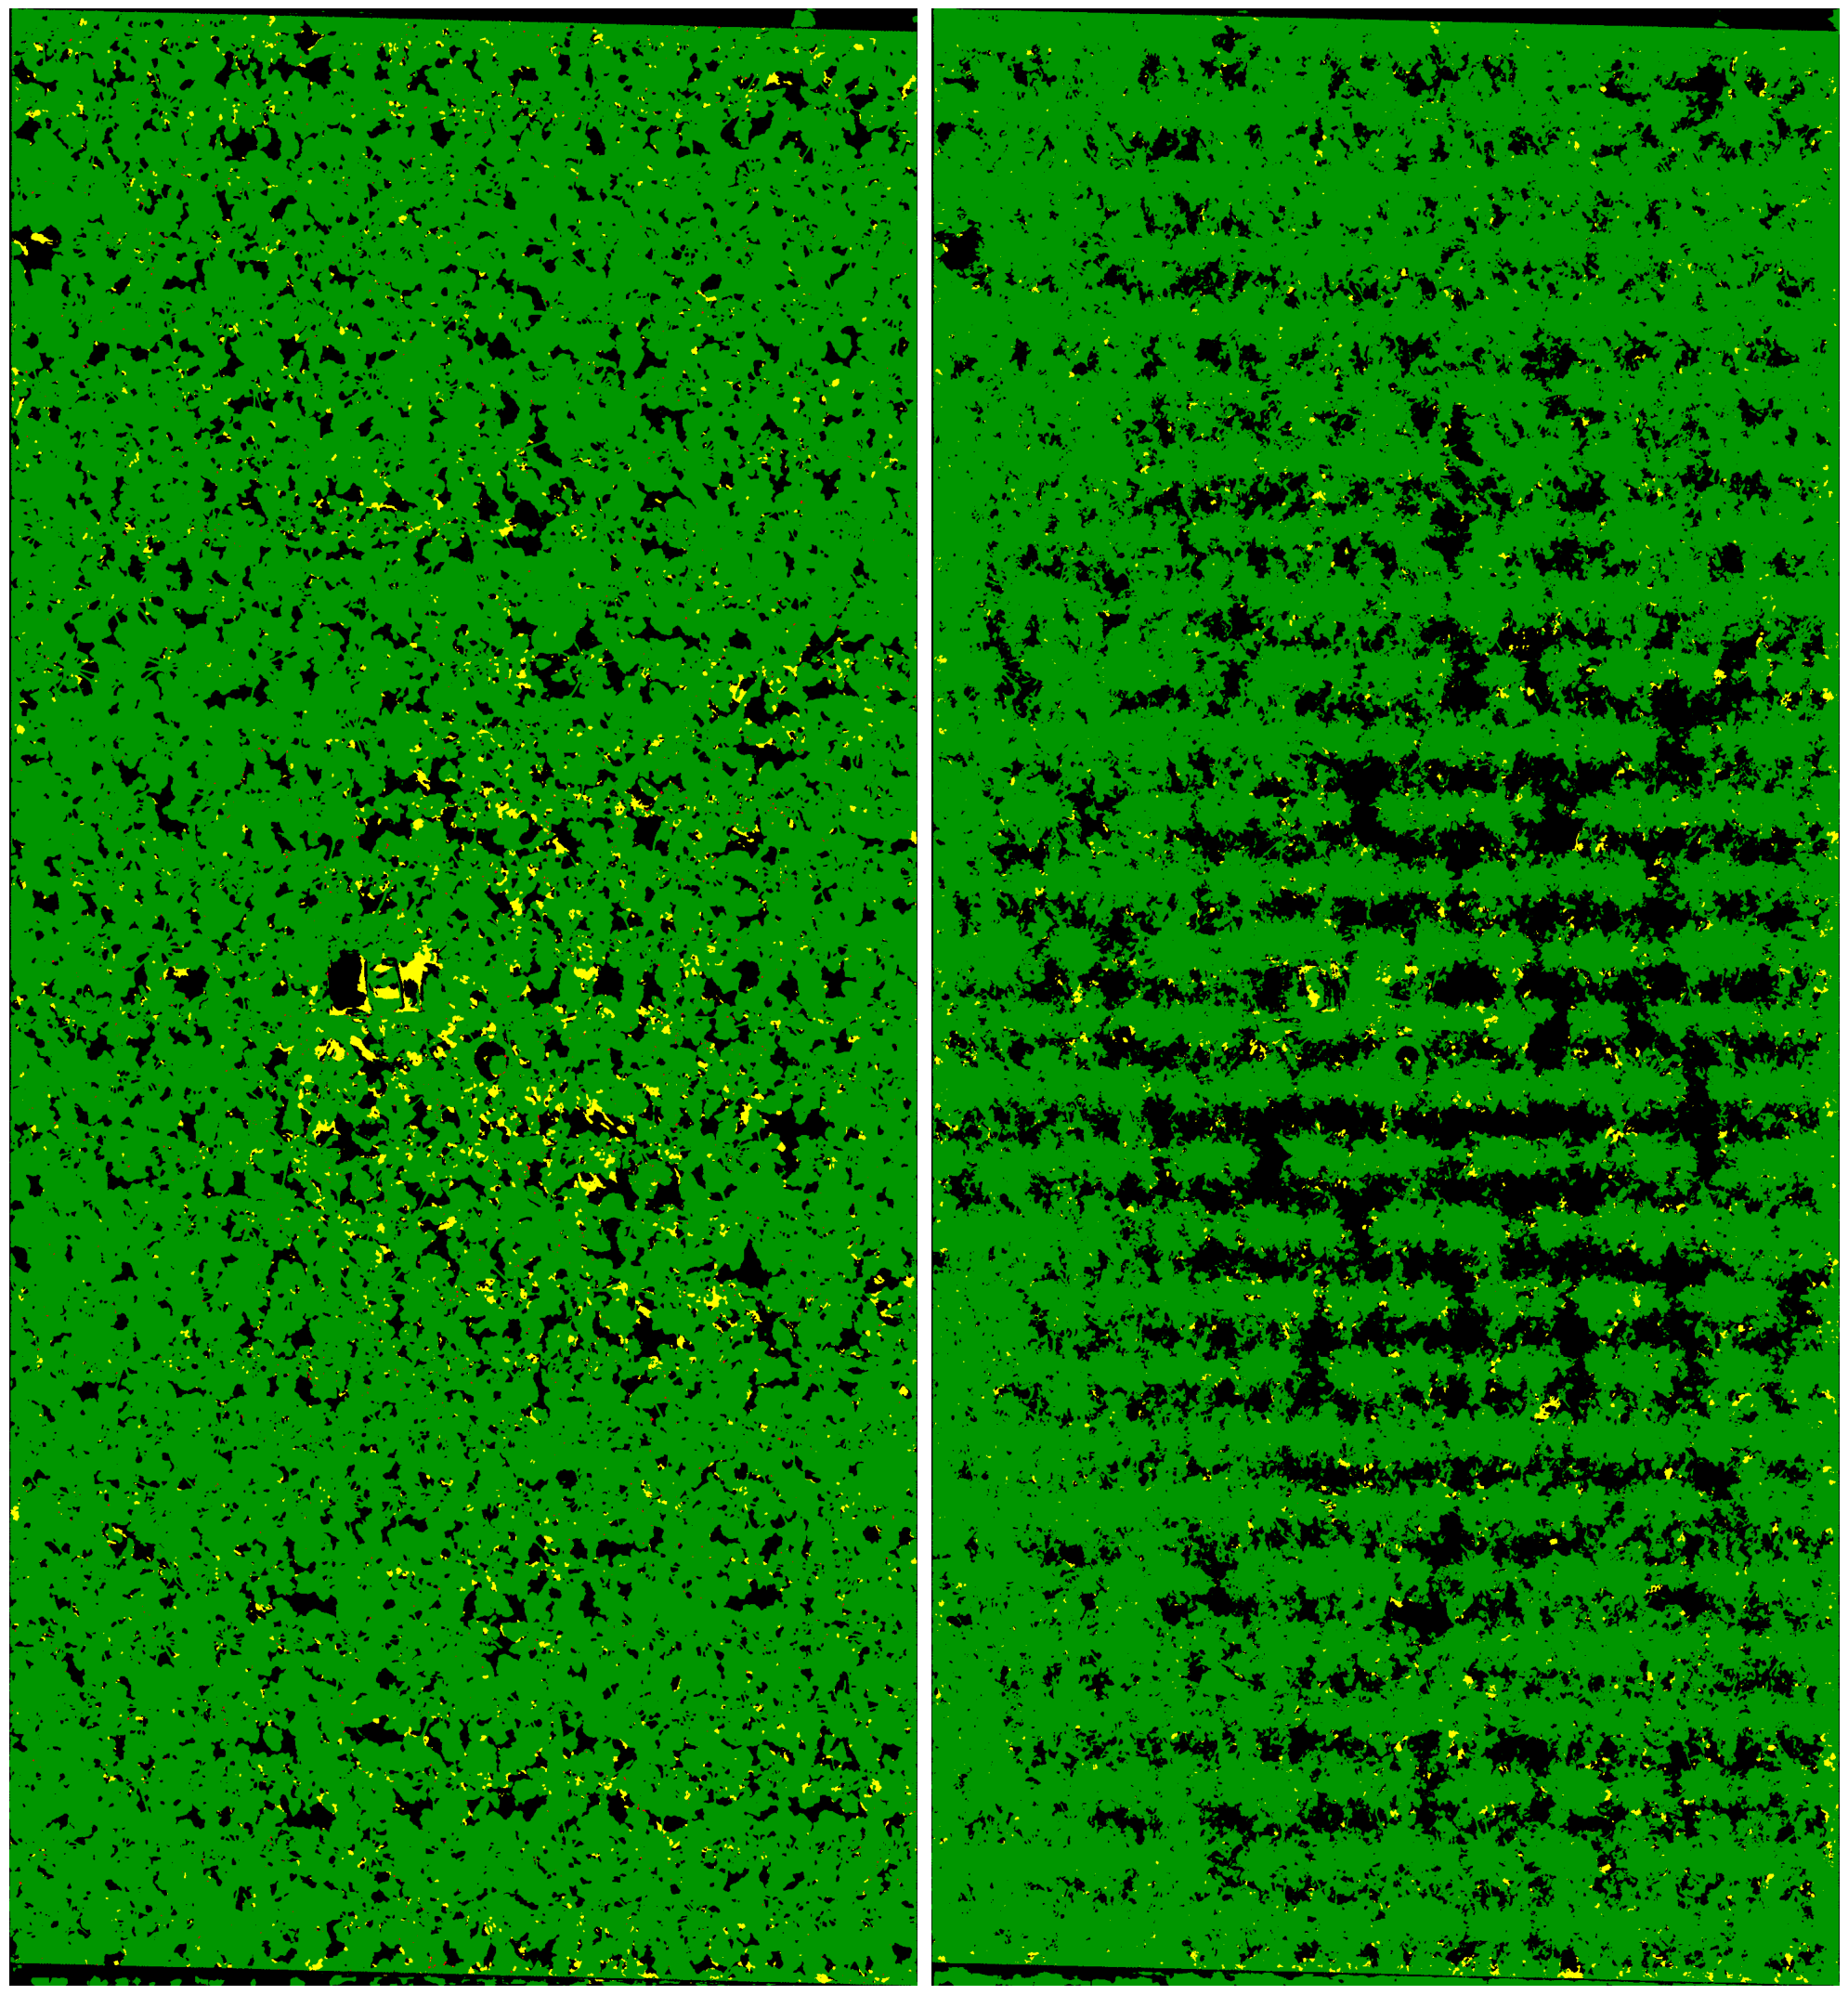

In [178]:
fig, axs = plt.subplots(1,2, figsize=(20,35))

axs[0].imshow(colored_pred_masks[0])
axs[0].axis('off')

axs[1].imshow(colored_pred_masks[4])
axs[1].axis('off')

plt.tight_layout()
plt.show()

# Inference with the plant detection

In [3]:
import geopandas as gpd
import glob
from matplotlib.patches import Rectangle
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from rasterio.transform import rowcol
from scipy.ndimage import rotate
import matplotlib.patches as patches
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# test_file = glob.glob('../data/test_tif/*')[0]
# test_file = time_tiffs[0]
time_tiffs = glob.glob('../by_plots/*')
geo_df = gpd.read_file('../data/plants_plot_1w.gpkg')


def read_tiff(file_path):
    with rasterio.open(file_path, 'r') as dataset:
        B,G,R, thermal = read_band(dataset, 1), read_band(dataset, 2), read_band(dataset, 3), read_band(dataset, 6)    
        # rededge, nir = read_band(dataset, 4), read_band(dataset, 5)
        rgb = np.dstack([R,G,B])
        data, nt, non_zero_rows, non_zero_cols = util(dataset, angle=0)
        transform = dataset.transform
        
    return data, transform

# Patch size
patch_size = 128
half_patch = patch_size // 2
rotation_angle = -13  # Rotation angle in degrees


# Function to calculate rotated bounding box coordinates
def calculate_rotated_bbox(center_col, center_row, patch_size, angle_deg):
    """
    Calculate the coordinates of the rotated bounding box.
    """
    half_patch = patch_size / 2
    angle_rad = np.radians(angle_deg)

    # Define the corners of the bounding box (relative to the center)
    corners = [
        (-half_patch, -half_patch),
        (-half_patch, half_patch),
        (half_patch, half_patch),
        (half_patch, -half_patch),
    ]

    # Rotate each corner around the center
    rotated_corners = []
    for x, y in corners:
        x_rot = x * np.cos(angle_rad) - y * np.sin(angle_rad)
        y_rot = x * np.sin(angle_rad) + y * np.cos(angle_rad)
        rotated_corners.append((x_rot + center_col, y_rot + center_row))

    return rotated_corners


def give_me_patches(data, transform):
    # Convert geometries to pixel coordinates and extract rotated patches
    rotated_patches = []
    height, width = data.shape[:2]
    # fig, ax = plt.subplots(figsize=(30, 30))
    # ax.imshow(data[...,:3])

    for _, row in geo_df.iterrows():
        if row['geometry'].geom_type == 'Point':
            # Convert geographic coordinates to pixel coordinates
            x, y = row['geometry'].x, row['geometry'].y
            col, row = ~transform * (x, y)  # Convert to pixel coordinates

            # Calculate the bounding box for the larger patch (to account for rotation)
            row_start = int(row - half_patch * 1.5)
            row_end = int(row + half_patch * 1.5)
            col_start = int(col - half_patch * 1.5)
            col_end = int(col + half_patch * 1.5)

            # Ensure the bounding box is within the image bounds
            if (row_start >= 0 and row_end <= height and col_start >= 0 and col_end <= width):
                # Extract the larger patch
                large_patch = data[row_start:row_end, col_start:col_end]

                # Rotate the larger patch
                rotated_patch = rotate(large_patch, angle=rotation_angle, reshape=False, mode="constant")

                # Extract the centered 128x128 patch from the rotated patch
                center_row, center_col = rotated_patch.shape[0] // 2, rotated_patch.shape[1] // 2
                patch = rotated_patch[center_row - half_patch:center_row + half_patch,center_col - half_patch:center_col + half_patch,]

                # Append the rotated and cropped patch
                rotated_patches.append(patch)

    return rotated_patches


                # Calculate the rotated bounding box coordinates
                # rotated_bbox = calculate_rotated_bbox(col, row, patch_size, rotation_angle)

                # Draw the rotated bounding box
                # polygon = patches.Polygon(rotated_bbox, closed=True, edgecolor="red", facecolor="none", linewidth=1.5)

    # Finalize the plot
    # plt.title("Rotated Bounding Boxes on Image")
    # plt.axis("off")
    # plt.show()

In [ ]:
import rasterio
from rasterio.warp import reproject, Resampling
from affine import Affine
import numpy as np
import matplotlib.pyplot as plt

def rotate_raster_and_plot_rgb(in_file, angle, shift_x=0, shift_y=0, adj_width=0, adj_height=0):
    with rasterio.open(in_file) as src:
        # Get the old transform and CRS
        src_transform = src.transform
        crs = src.crs

        # Affine transformations for rotation and translation
        rotate = Affine.rotation(angle)
        trans_x = Affine.translation(shift_x, 0)
        trans_y = Affine.translation(0, -shift_y)

        # Combine affine transformations
        dst_transform = src_transform * rotate * trans_x * trans_y

        # Get band data for RGB (bands 1, 2, 3)
        bands = [read_band(src, idx=idx) for idx in [3, 2, 1]]  # R, G, B order

        # Get the new shape
        y, x = bands[0].shape
        dst_height = y + adj_height
        dst_width = x + adj_width

        # Define properties for the output raster
        dst_kwargs = src.meta.copy()
        dst_kwargs.update(
            {
                "transform": dst_transform,
                "height": dst_height,
                "width": dst_width,
                "nodata": 0,
            }
        )

        # Prepare an empty array for each reprojected band
        dst_bands = [np.zeros((dst_height, dst_width), dtype=band.dtype) for band in bands]

        # Reproject each band
        for i, band in enumerate(bands):
            reproject(
                source=band,
                destination=dst_bands[i],
                src_transform=src_transform,
                src_crs=crs,
                dst_transform=dst_transform,
                dst_crs=crs,
                resampling=Resampling.nearest,
            )

        # Stack the bands back into an RGB image
        dst_array = np.stack(dst_bands, axis=-1)

        # Plot the rotated and translated RGB image
        plt.figure(figsize=(10, 10))
        plt.imshow(dst_array)
        plt.title("Rotated and Translated Raster (RGB)")
        plt.axis("off")
        plt.show()


# Apply the function to rotate by 30 degrees and shift the image
rotate_raster_and_plot_rgb(test_file, angle=-12.5, shift_x=-300, shift_y=-200)

In [ ]:
import rasterio
from rasterio.warp import reproject, Resampling
from rasterio.transform import Affine
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd

def geographic_to_pixel_coords(geo_df, src):
    """
    Convert geographic coordinates to pixel coordinates
    """
    pixel_coords = []
    for point in geo_df.geometry:
        # Convert geographic coordinates (lon, lat) to pixel coordinates (row, col)
        row, col = rasterio.transform.rowcol(src.transform, point.x, point.y)
        pixel_coords.append((col + 0.5, row + 0.5))  # Offset to align with pixel center
    return pixel_coords

def rotate_point(point, angle_deg, center_x, center_y):
    """
    Rotate a point around a center point by given angle in degrees
    """
    angle_rad = np.radians(angle_deg)
    # Translate point to origin
    translated_x = point[0] - center_x
    translated_y = point[1] - center_y
    # Rotate
    rotated_x = translated_x * np.cos(angle_rad) - translated_y * np.sin(angle_rad)
    rotated_y = translated_x * np.sin(angle_rad) + translated_y * np.cos(angle_rad)
    # Translate back
    final_x = rotated_x + center_x
    final_y = rotated_y + center_y
    return (final_x, final_y)

def rotate_raster_and_plot_with_points(in_file, geo_df, angle, shift_x=0, shift_y=0, adj_width=0, adj_height=0):
    with rasterio.open(in_file) as src:
        # Get the old transform and CRS
        src_transform = src.transform
        crs = src.crs

        # Convert geographic coordinates to pixel coordinates
        pixel_coords = geographic_to_pixel_coords(geo_df, src)

        # Get center of the image for rotation (use updated transform for precision)
        center_x, center_y = src.width / 2 + shift_x, src.height / 2 + shift_y

        # Rotate pixel coordinates
        rotated_coords = [
            rotate_point(point, -angle, center_x, center_y)
            for point in pixel_coords
        ]

        # Apply shifts to rotated coordinates
        shifted_coords = [
            (x + shift_x, y + shift_y) 
            for x, y in rotated_coords
        ]

        # Affine transformations for rotation and translation
        rotate = Affine.rotation(angle)
        trans_x = Affine.translation(shift_x, 0)
        trans_y = Affine.translation(0, -shift_y)

        # Combine affine transformations
        dst_transform = src_transform * rotate * trans_x * trans_y

        # Get band data for RGB (bands 1, 2, 3)
        bands = [src.read(idx) for idx in [3, 2, 1]]  # R, G, B order

        # Get the new shape
        y, x = bands[0].shape
        dst_height = y + adj_height
        dst_width = x + adj_width

        # Define properties for the output raster
        dst_kwargs = src.meta.copy()
        dst_kwargs.update({
            "transform": dst_transform,
            "height": dst_height,
            "width": dst_width,
            "nodata": 0,
        })

        # Prepare an empty array for each reprojected band
        dst_bands = [np.zeros((dst_height, dst_width), dtype=band.dtype) for band in bands]

        # Reproject each band
        for i, band in enumerate(bands):
            reproject(
                source=band,
                destination=dst_bands[i],
                src_transform=src_transform,
                src_crs=crs,
                dst_transform=dst_transform,
                dst_crs=crs,
                resampling=Resampling.nearest,
            )

        # Stack the bands back into an RGB image
        dst_array = np.stack(dst_bands, axis=-1)

        # Plot the rotated and translated RGB image with points
        plt.figure(figsize=(10, 10))
        plt.imshow(dst_array)
        
        # Plot transformed points
        x_coords, y_coords = zip(*shifted_coords)
        plt.scatter(x_coords, y_coords, c='red', s=30, alpha=0.7, label='Plants')
        
        plt.title("Rotated and Translated Raster with Points")
        plt.legend()
        plt.axis("off")
        plt.show()

        return shifted_coords

# Example usage:
rotate_raster_and_plot_with_points(
    test_file, geo_df, angle=-12.5, shift_x=-300, shift_y=-200
)


In [26]:
import cv2

def gamma_correct_rgb(rgb, gamma=1.5):
    gaussian_rgb = cv2.GaussianBlur(rgb, (9,9), 10.0)
    gaussian_rgb[gaussian_rgb<0] = 0
    gaussian_rgb[gaussian_rgb>1] = 1

    unsharp_rgb = cv2.addWeighted(rgb, 1.5, gaussian_rgb, -0.5, 0)
    unsharp_rgb[unsharp_rgb<0] = 0
    unsharp_rgb[unsharp_rgb>1] = 1
    # Apply a gamma correction to make the render appear closer to what our eyes would see
    return unsharp_rgb**(1.0/gamma)

In [6]:
from tqdm.notebook import tqdm
import os

In [ ]:
mapping = {
    0: "background",
    1: "plant",
    2: "sick",
    3: "spot"
}

for tiff_file_path in tqdm(time_tiffs):
    data, transform = read_tiff(file_path=tiff_file_path)
    patches = give_me_patches(data=data, transform=transform)
    test_preds = []

    for test_img in patches:
        img = torch.tensor(test_img).permute(-1,0,1).unsqueeze(0).cuda()
        pred = torch.softmax(best_model(img.cuda()).detach().cpu(), dim=1)
        pred = torch.argmax(pred,dim=1)
        test_preds.append(pred)

    test_preds = torch.concat(test_preds)
    
    df_rows = []
    

    for i in range(geo_df.shape[0]):
        plant_id, geometry = geo_df.iloc[i]
        df_row = {
            "plant_id": plant_id,
            "coordinates": (geometry.x, geometry.y)
        }
        
        classes, counts = test_preds[i].unique(return_counts=True)
        counts = counts / counts.sum()
        for j in classes:
            df_row[mapping[classes[j].item()]] = counts[j].item()
        
        df_rows.append(df_row)
    
    pd.DataFrame(df_rows).to_csv(f"./{os.path.basename(tiff_file_path).replace('.tif','.csv')}")

  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
test_preds = []

for test_img in rotated_patches:
    # img = torch.tensor(normalize(test_img, max_percentile=99)).permute(-1,0,1).unsqueeze(0).cuda()
    img = torch.tensor(test_img).permute(-1,0,1).unsqueeze(0).cuda()
    pred = torch.softmax(best_model(img.cuda()).detach().cpu(), dim=1)
    pred = torch.argmax(pred,dim=1)
    test_preds.append(pred)

test_preds = torch.concat(test_preds)

In [ ]:
idx = 17

fig, axs = plt.subplots(1,2,figsize=(10,5))
axs[0].imshow(test_preds[idx])
axs[0].axis('off')

axs[1].imshow(gamma_correct_rgb(normalize(rotated_patches[idx][...,:3], max_percentile=99)))
axs[1].axis('off')

plt.tight_layout()
plt.show()

fig, axs = plt.subplots(1,2,figsize=(10,5))
axs[0].imshow(test_preds[idx])
axs[0].axis('off')

axs[1].imshow(rotated_patches[idx][...,:3])
axs[1].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
idx = 17

fig, axs = plt.subplots(1,2,figsize=(10,5))
axs[0].imshow(test_preds[idx])
axs[0].axis('off')

axs[1].imshow(gamma_correct_rgb(normalize(rotated_patches[idx][...,:3], max_percentile=99)))
axs[1].axis('off')

plt.tight_layout()
plt.show()

fig, axs = plt.subplots(1,2,figsize=(10,5))
axs[0].imshow(test_preds[idx])
axs[0].axis('off')

axs[1].imshow(rotated_patches[idx][...,:3])
axs[1].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
from scipy.ndimage import gaussian_filter

# Assuming full image and weight_sum are tensors now
# full_height, full_width, num_classes = 3182, 1460, 4
full_height, full_width, num_classes = 3182, 1461, 4
full_image = torch.zeros((full_height, full_width, num_classes), dtype=torch.float32)
weight_sum = torch.zeros((full_height, full_width, 1), dtype=torch.float32)

# Define base_weight_mask in NumPy and convert to torch.Tensor for consistency
base_weight_mask_np = np.zeros((128, 128))
base_weight_mask_np[64, 64] = 1
base_weight_mask_np = gaussian_filter(base_weight_mask_np, sigma=32)
base_weight_mask = torch.tensor(base_weight_mask_np, dtype=torch.float32)

# Iterate over patches and apply weight mask
patch_size, stride = 128, 64
patch_index = 0

In [ ]:
final_masks = []
for test_pred in tqdm(all_preds):
    patch_index = 0
    for y in range(0, full_height, stride):
        for x in range(0, full_width, stride):
            patch = test_pred[patch_index]
            
            # Adjust weight mask for edge patches
            weight_mask = base_weight_mask.clone()  # Ensure a fresh copy for each patch
            if y + patch_size > full_height:
                weight_mask[(full_height - y):, :] = 0
            if x + patch_size > full_width:
                weight_mask[:, (full_width - x):] = 0

            # Apply adjusted weight mask to the patch
            # print(patch.shape, weight_mask.shape)
            weighted_patch = patch * weight_mask[..., None]

            # Define slice range
            y_end = min(y + patch_size, full_height)
            x_end = min(x + patch_size, full_width)

            # Accumulate predictions and weights
            full_image[y:y_end, x:x_end] = full_image[y:y_end, x:x_end] + weighted_patch[:y_end - y, :x_end - x]
            weight_sum[y:y_end, x:x_end] = weight_sum[y:y_end, x:x_end] + weight_mask[:y_end - y, :x_end - x, None]

            patch_index += 1
            
    full_image /= torch.maximum(weight_sum, torch.tensor(1.0))
    final_prediction = torch.argmax(full_image, dim=-1)
    final_masks.append(final_prediction)

In [ ]:
colored_pred_masks = []

for test_pred_mask in final_masks:
    if isinstance(test_pred_mask, torch.Tensor):
        test_pred_mask = test_pred_mask.numpy()
    # final_image = (final_prediction * (255 / final_prediction.max())).astype(np.uint8)
    # image = Image.fromarray(final_image)
    # image.save("test_prediction_mask.png", dpi=(600, 600))

    color_map = {
        0: (0, 0, 0),         # Background - Black
        1: (0, 150, 0),       # Class 1 - Green
        2: (255, 255, 0),     # Class 2 - Yellow
        3: (255, 0, 0),       # Class 3 - Red
    }

    height, width = test_pred_mask.shape
    color_image = np.zeros((height, width, 3), dtype=np.uint8)

    for class_index, color in color_map.items():
        color_image[test_pred_mask == class_index] = color

    colored_pred_masks.append(color_image)
    # Image.fromarray(color_image).save("test_prediction_color_mask.png", dpi=(600, 600))

# ROUGH

In [11]:
from rasterio.warp import transform_bounds, transform
from shapely.geometry import box
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import rasterio
import os
from rasterio.transform import rowcol

In [5]:
time_tiffs = glob.glob('../by_plots/*')
geo_df = gpd.read_file('../data/plants_plot_1w.gpkg')

In [20]:
from pyproj import Transformer

# Open the raster
with rasterio.open(time_tiffs[0]) as src:
    transform = src.transform  # Affine transform
    crs = src.crs  # CRS of the raster
    bounds = src.bounds  # Bounding box of the raster

    # Pixel size in degrees (if CRS is geographic)
    pixel_size_x_deg = abs(transform.a)
    pixel_size_y_deg = abs(transform.e)

    # Check if CRS is geographic
    if crs.is_geographic:
        # Use pyproj to convert degrees to meters at the raster's center latitude
        center_lat = (bounds.top + bounds.bottom) / 2
        transformer = Transformer.from_crs(crs, "EPSG:32633", always_xy=True)  # Convert to meters (Web Mercator)

        # Convert pixel size from degrees to meters
        scale_x, _ = transformer.transform(bounds.left + pixel_size_x_deg, center_lat)
        _, scale_y = transformer.transform(bounds.left, center_lat - pixel_size_y_deg)
        pixel_size_x_m = abs(scale_x - bounds.left)
        pixel_size_y_m = abs(scale_y - center_lat)

        print(f"Pixel size in meters: x = {pixel_size_x_m}, y = {pixel_size_y_m}")
    else:
        # CRS is already in meters
        pixel_size_x_m = abs(transform.a)
        pixel_size_y_m = abs(transform.e)
        print(f"Pixel size is already in meters: x = {pixel_size_x_m}, y = {pixel_size_y_m}")


Pixel size in meters: x = 147500.01411191953, y = 5724436.864151774


In [ ]:
# Pixel size in meters: x = 1103556.9039792703, y = 6721091.925574105

In [ ]:
with rasterio.open(time_tiffs[0]) as src:
    data, nt = util(dataset=src, angle=0)
    transform = src.transform
    bounds = src.bounds
    
    # bottom_left = rowcol(transform, bounds.left, bounds.bottom)
    # bottom_right = rowcol(transform, bounds.right, bounds.bottom)
    # top_left = rowcol(transform, bounds.left, bounds.top)
    # top_right = rowcol(transform, bounds.right, bounds.top)
    
    # points = np.array([
    #     [bottom_left[1], bottom_left[0]],
    #     [bottom_right[1], bottom_right[0]],
    #     [top_left[1], top_left[0]],
    #     [top_right[1], top_right[0]],
    # ])

    plt.figure(figsize=(10,10))
    plt.imshow(normalize(data[...,:3], max_percentile=99))
    # plt.scatter(x=points[1,0], y=points[1,1])
    plt.axis('off')
    plt.show()


In [8]:
from rasterio.warp import transform_bounds

file_path = time_tiffs[0]

with rasterio.open(file_path) as dataset:
    bounds = dataset.bounds
    target_crs = "EPSG:32633"  # Example UTM CRS
    bounds_meters = transform_bounds(dataset.crs, target_crs, *bounds)
    print("Bounds in meters:", bounds_meters)

Bounds in meters: (147509.45585872163, 5724481.122227169, 147518.96416922117, 5724495.138482706)


In [22]:
from rasterio.warp import transform_bounds, transform
from shapely.geometry import box
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import rasterio
from rasterio.transform import rowcol

# File paths
image_file = time_tiffs[0]
plant_file = "../data/plants_plot_1w.gpkg"

# Load the raster and its CRS
with rasterio.open(image_file) as dataset:
    image_crs = dataset.crs
    transform = dataset.transform
    image, nt = util(dataset, angle=0)

# Load plant coordinates
geo_df = gpd.read_file(plant_file)

# Define the UTM CRS (adjust for your region if needed)
utm_crs = geo_df.to_crs(epsg=32633).crs

# Reproject plant coordinates to UTM (meters)
geo_df_utm = geo_df.to_crs(utm_crs)

# Define box size in meters (48x48 cm = 0.48 meters)
box_size = 0.24  # Half of 48 cm

# Create boxes around each plant in UTM coordinates
boxes = []
for idx, row in geo_df_utm.iterrows():
    x, y = row.geometry.x, row.geometry.y
    bbox = box(x - box_size, y - box_size, x + box_size, y + box_size)
    boxes.append(bbox)


# Convert boxes back to the original CRS (latitude/longitude)
boxes_gdf = gpd.GeoDataFrame({'geometry': boxes}, crs=utm_crs).to_crs(image_crs)


# Plot the raster and boxes
fig, ax = plt.subplots(figsize=(10, 10))
# For RGB images, stack the bands
ax.imshow(image[...,:3])

# Draw the boxes
for bbox in boxes_gdf.geometry:
    minx, miny, maxx, maxy = bbox.bounds
    row_min, col_min = rowcol(transform, minx, maxy)
    row_max, col_max = rowcol(transform, maxx, miny)
    rect = Rectangle((col_min, row_min), col_max - col_min, row_max - row_min, 
                     linewidth=1, edgecolor="red", facecolor="none")
    ax.add_patch(rect)

# Plot plant centers using scatter
# ax.scatter(rows, cols, color='blue', s=10, label='Plant Centers')

# Finalize plot
plt.title("Plant Coordinates with 48x48 cm Boxes")
plt.xlabel("Pixel Column")
plt.ylabel("Pixel Row")
plt.axis('off')
plt.legend()
plt.gca()  # Match raster coordinate system
plt.show()

C:\Users\Akshat\AppData\Local\Temp\ipykernel_22780\4059820454.py:65: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


In [32]:
import numpy as np
from rasterio.transform import rowcol

# Define box size in meters (48 cm = 0.48 meters)
box_size = 0.24  # Half of 48 cm

# List to store patches
patches = []

# Loop through each plant to extract patches
for bbox in boxes_gdf.geometry:
    minx, miny, maxx, maxy = bbox.bounds

    # Convert bounding box to pixel coordinates
    row_min, col_min = rowcol(transform, minx, maxy)
    row_max, col_max = rowcol(transform, maxx, miny)

    # Ensure bounding box is within image bounds
    if 0 <= row_min < image.shape[0] and 0 <= row_max < image.shape[0] and \
       0 <= col_min < image.shape[1] and 0 <= col_max < image.shape[1]:
        # Extract the patch
        patch = image[row_min:row_max, col_min:col_max, :]
        patches.append(patch)

# Save patches as NumPy arrays
# for i, patch in enumerate(patches):
#     np.save(f"patch_{i}.npy", patch)

# print(f"Extracted and saved {len(patches)} patches as NumPy arrays.")

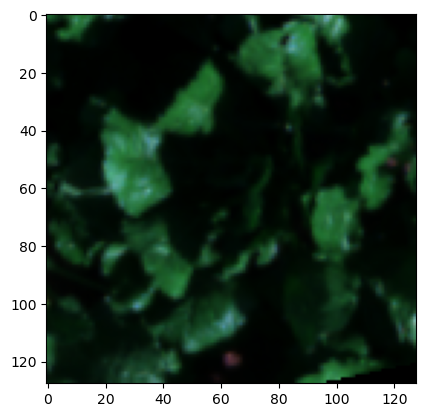

In [36]:
plt.imshow(patches[0][...,:3])

In [31]:
plt.imshow(gamma_correct_rgb(normalize(patches[0][...,:3], max_percentile=99.5), gamma=2.0))
plt.axis('off')
plt.show()

In [68]:
for tiff_path in time_tiffs:
    with rasterio.open(tiff_path) as dataset:
        print(os.path.basename(tiff_path), ":", "pixel size x: ", dataset.transform.a, "pixel size y: ", -dataset.transform.e)
        print()
        # print(os.path.basename(tiff_path).rstrip('.tiff'),": ", dataset.transform)

1w_20200722_Multi_ortho.tif : pixel size x:  5.7679900000030955e-08 pixel size y:  3.5952200000037264e-08

1w_20200810_multi_ortho.tif : pixel size x:  5.767990000001962e-08 pixel size y:  3.595220000001655e-08

1w_20200903_Multi_ortho.tif : pixel size x:  5.767990000001114e-08 pixel size y:  3.595219999999106e-08

1w_20200922_Multi_ortho.tif : pixel size x:  5.7679899999989504e-08 pixel size y:  3.595219999997974e-08

1w_20201012_Multi_ortho.tif : pixel size x:  5.767990000002688e-08 pixel size y:  3.5952200000050307e-08

